## Task 0: import data

1. Create folder called data next to main.ipynb
1. Create file called .gitignore next to main.ipynb. In this write: data/
1. Download data between 01-01-2021 and 01-01-2022
    1. Nordpool - hourly prices in DKK
    1. Bornholm network manager - kirkeby Sose Vindpark Active Power
    1. Digital Energy Lab/Weather Observations/DMI - All streams from Bornholm
1. Place data files under /data and rename to production, prices, and weather

## Task 1: Optimization model

In [1]:
import gurobipy as gp
from gurobipy import GRB

# Create optimization model for bidding strategy in DA and balancing market
# Probably good to write it as a class or function for easier repeated use 

## Task 2: Data collection

Want to determine some features that we believe will be useful predictors of future wind power. Could be previous wind power, features of the weather, season or similar. 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import StandardScaler

# Import and format relevant data 
# Import production data
production = pd.read_csv('data/production.csv')
production['ts'] = pd.to_datetime(production['ts']) # Convert to datetime
production = production.set_index('ts') # Set datetime as index
production = production.resample('H').mean() # Resample to hourly data
production = production.rename(columns={"kirkeby Sose Vindpark Active Power | aki_sov_effekt | 804128": "power"}) # Rename column
production = production.fillna(0) # Fill missing values with 0
production = -1 * production # Change sign to positive for production

# Import weather data
weather = pd.read_csv('data/weather.csv')
weather['ts'] = pd.to_datetime(weather['ts'])
weather = weather.set_index('ts')
weather = weather.resample('H').mean()
weather = weather.fillna(0)

# Import electricity prices
prices = pd.read_csv('data/prices.csv')
prices['ts'] = pd.to_datetime(prices['ts'])
prices = prices.set_index('ts')
prices = prices.rename(columns = {"Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820": "spotprice"})


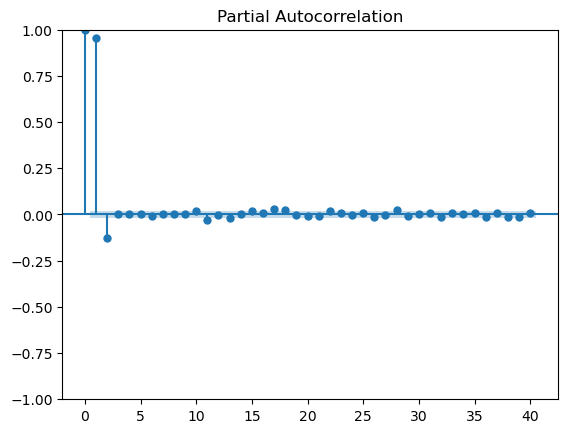

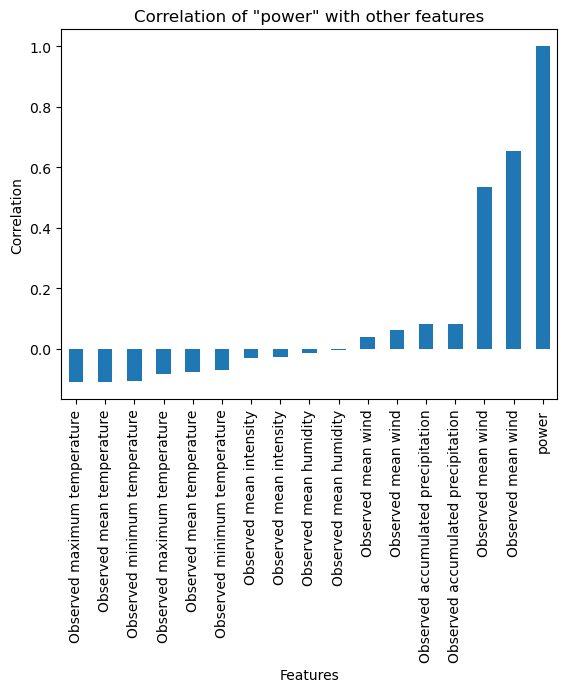

In [48]:
# Check autorrelation of power production
tsaplots.plot_pacf(production)
plt.show()

# Check correlation between features
data = pd.merge(production, weather, left_index=True, right_index=True)

# Shorten the column names to first three words
data.columns = data.columns.str.split().str[:3].str.join(' ')

data.corr().iloc[:, 0].sort_values().plot(kind='bar')
plt.title('Correlation of "power" with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()


In [60]:
# Choose relevant features
x = np.arange(100).reshape(-1,1) # Dummy data
y = x + np.random.rand(100).reshape(-1,1) # Dummy data

# Scale data 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Add bias term to input data
X = np.concatenate([np.ones((x.shape[0], 1)), x_scaled], axis=1)

# Split data into training and test set for time series data
split_fraction = 0.8
split_index = int(len(x) * split_fraction)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## Task 3: Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression




# Implement gradient descent
theta_gd = ...
# Implement closed form solution
theta_cfs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Compare the two solutions
# print(theta_gd)
print(theta_cfs)


# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

[[50.01446434]
 [28.91351889]]


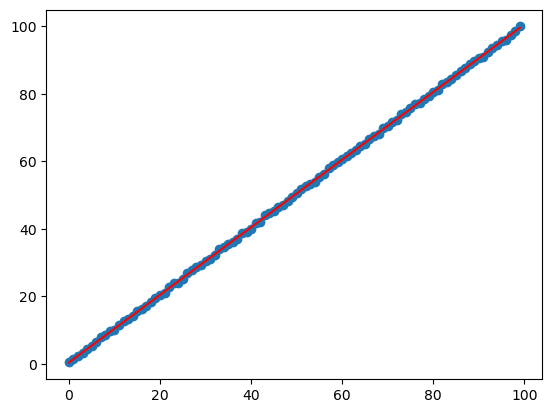

In [62]:
plt.scatter(x,y)
plt.plot(x, X @ theta_cfs, color='red')

## Task 4: Non-linear regression

In [52]:
# Implement polynomial regression
from sklearn.preprocessing import PolynomialFeatures


# Implement weighted least squares
# Possible kernels
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return kern

def tricube(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return kern

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return kern



## Task 5: Regularization

In [53]:
from sklearn.linear_model import Ridge, Lasso

# Implement manually?


## Task 6: Revenue calculation for evaluation

## Task 7 (optional): Suggestion for improvement

c:\Users\jacob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


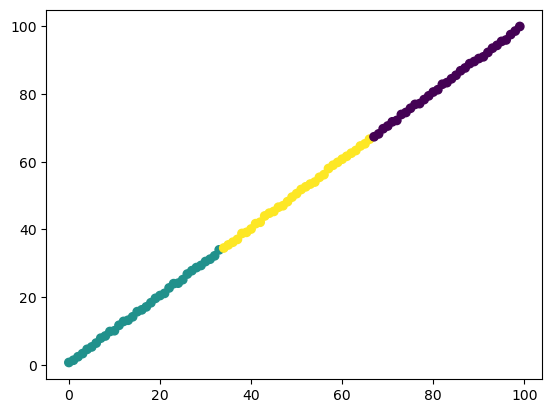

c:\Users\jacob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jacob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jacob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jacob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

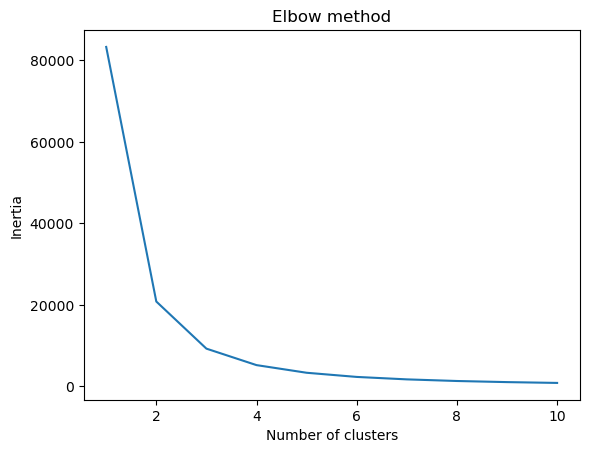

In [79]:
from sklearn.cluster import KMeans


# Implement clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(x).astype('int')

# Plot clusters
plt.scatter(x, y, c=clusters)
plt.show()

# Implement the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

## Task 8: Model 2